In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets
from torchvision.transforms import v2
from torch.utils.data import DataLoader
from torch.utils.data import DataLoader, Dataset
import timm
from utils import *
from utils import check_accuracy_final
import matplotlib.pyplot as plt


In [2]:
class CropButtonDataset(Dataset):
    def __init__(self, data_dir, transform=None):
        self.data = datasets.ImageFolder(data_dir, transform=transform)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]

    def classes(self):
        return self.data.classes

In [3]:
# 设置设备和参数
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
batch_size = 128
epochs = 24
learning_rate = 1e-3

pretrain_network = 'resnet18'

In [4]:
# 准备数据
# transform = transforms.Compose([
#     transforms.Resize(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.5]*3, [0.5]*3)
# ])

transform = v2.Compose([
                v2.ToImage(), 
                v2.ToDtype(torch.float32, scale=True),
                v2.ColorJitter(brightness=(0.5, 1.5), contrast=(0.5, 1.5), saturation=(0.5, 1.5), hue=(-0.3, 0.3)),
                v2.RandomChannelPermutation(),
                v2.RandomErasing(p=0.55, scale=(0.05, 0.3), ratio=(1, 1), value='random'),
                v2.RandomRotation(degrees=30)])



train_dataset = CropButtonDataset("../ClassificationDataset_label/train", transform=transform)
val_dataset   = CropButtonDataset("../ClassificationDataset_label/val", transform=transform)
test_dataset  = CropButtonDataset("../ClassificationDataset_label/test", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)



In [5]:
# 加载模型
model = timm.create_model('resnet18', pretrained=True)
in_features = model.get_classifier().in_features

# custom MLP head
mlp_head = nn.Sequential(
    nn.Linear(in_features, 256),
    nn.ReLU(),
    nn.Linear(256,128),
    nn.ReLU(),
    nn.Linear(128, 64),
    nn.ReLU(),
    nn.Linear(64, 1),
    #nn.Linear(in_features, 1),

)

model.reset_classifier(0)  # 移除原有头部
model.fc = mlp_head        # 或 model.head = mlp_head，取决于模型定义


# # 加载模型
# model = timm.create_model(pretrain_network, pretrained=True)
# model.reset_classifier(num_classes=1)


model.to(device)

# 损失函数和优化器
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate) 


Epoch 1/24
Train ‑ loss: 0.6906, acc: 54.95%
Val   ‑ loss: 0.6922, acc: 50.00%

Epoch 2/24
Train ‑ loss: 0.6889, acc: 54.95%
Val   ‑ loss: 0.6925, acc: 50.00%

Epoch 3/24
Train ‑ loss: 0.6872, acc: 54.95%
Val   ‑ loss: 0.6923, acc: 50.00%

Epoch 4/24
Train ‑ loss: 0.6800, acc: 54.95%
Val   ‑ loss: 0.6913, acc: 50.00%

Epoch 5/24
Train ‑ loss: 0.6785, acc: 54.95%
Val   ‑ loss: 0.6886, acc: 50.00%

Epoch 6/24
Train ‑ loss: 0.6651, acc: 54.95%
Val   ‑ loss: 0.6895, acc: 50.00%

Epoch 7/24
Train ‑ loss: 0.6523, acc: 54.95%
Val   ‑ loss: 0.6841, acc: 50.00%

Epoch 8/24
Train ‑ loss: 0.6213, acc: 56.04%
Val   ‑ loss: 0.6893, acc: 55.00%

Epoch 9/24
Train ‑ loss: 0.6169, acc: 57.14%
Val   ‑ loss: 0.6847, acc: 55.00%

Epoch 10/24
Train ‑ loss: 0.5569, acc: 65.93%
Val   ‑ loss: 0.6630, acc: 60.00%

Epoch 11/24
Train ‑ loss: 0.5072, acc: 69.23%
Val   ‑ loss: 0.6436, acc: 60.00%

Epoch 12/24
Train ‑ loss: 0.4632, acc: 79.12%
Val   ‑ loss: 0.6505, acc: 60.00%

Epoch 13/24
Train ‑ loss: 0.4147, ac

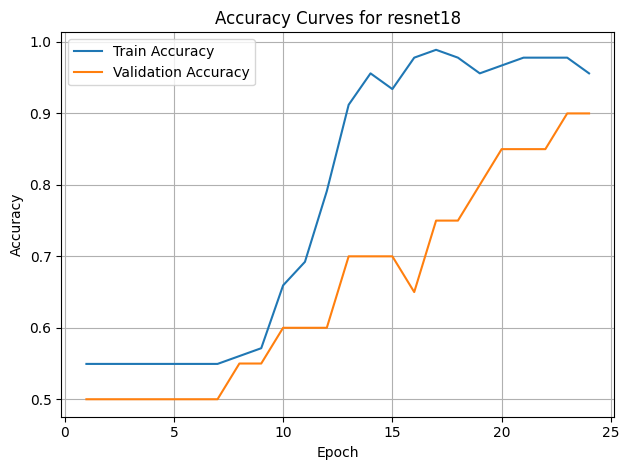

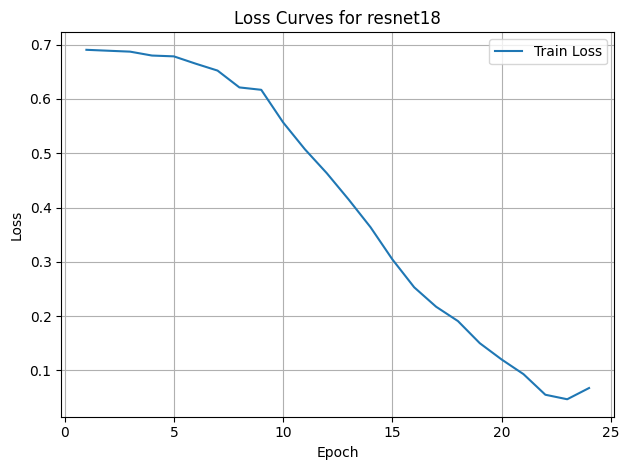

In [11]:
# 训练+画图

train_acc, val_acc, train_loss, val_loss = train(
    model, train_loader, val_loader,
    optimizer, criterion, device,
    epochs=epochs,
    early_stopping_patience=7
)

plot_accuracy_curves(
    train_acc, val_acc,
    train_loss=train_loss,
    val_loss=val_loss,
    model_name="resnet18"
)




In [12]:
from torchinfo import summary
info = summary(model, input_size=(1, 3, 320, 320))

with open("model_summary.txt", "w") as f:
    f.write(str(info))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.5150537..4.0054173].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.1275544..3.6975203].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.2262945..4.381387].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.518161..4.4815907].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.386128..4.4516873].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-4.6985793..4.2486215].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-3.6211228..

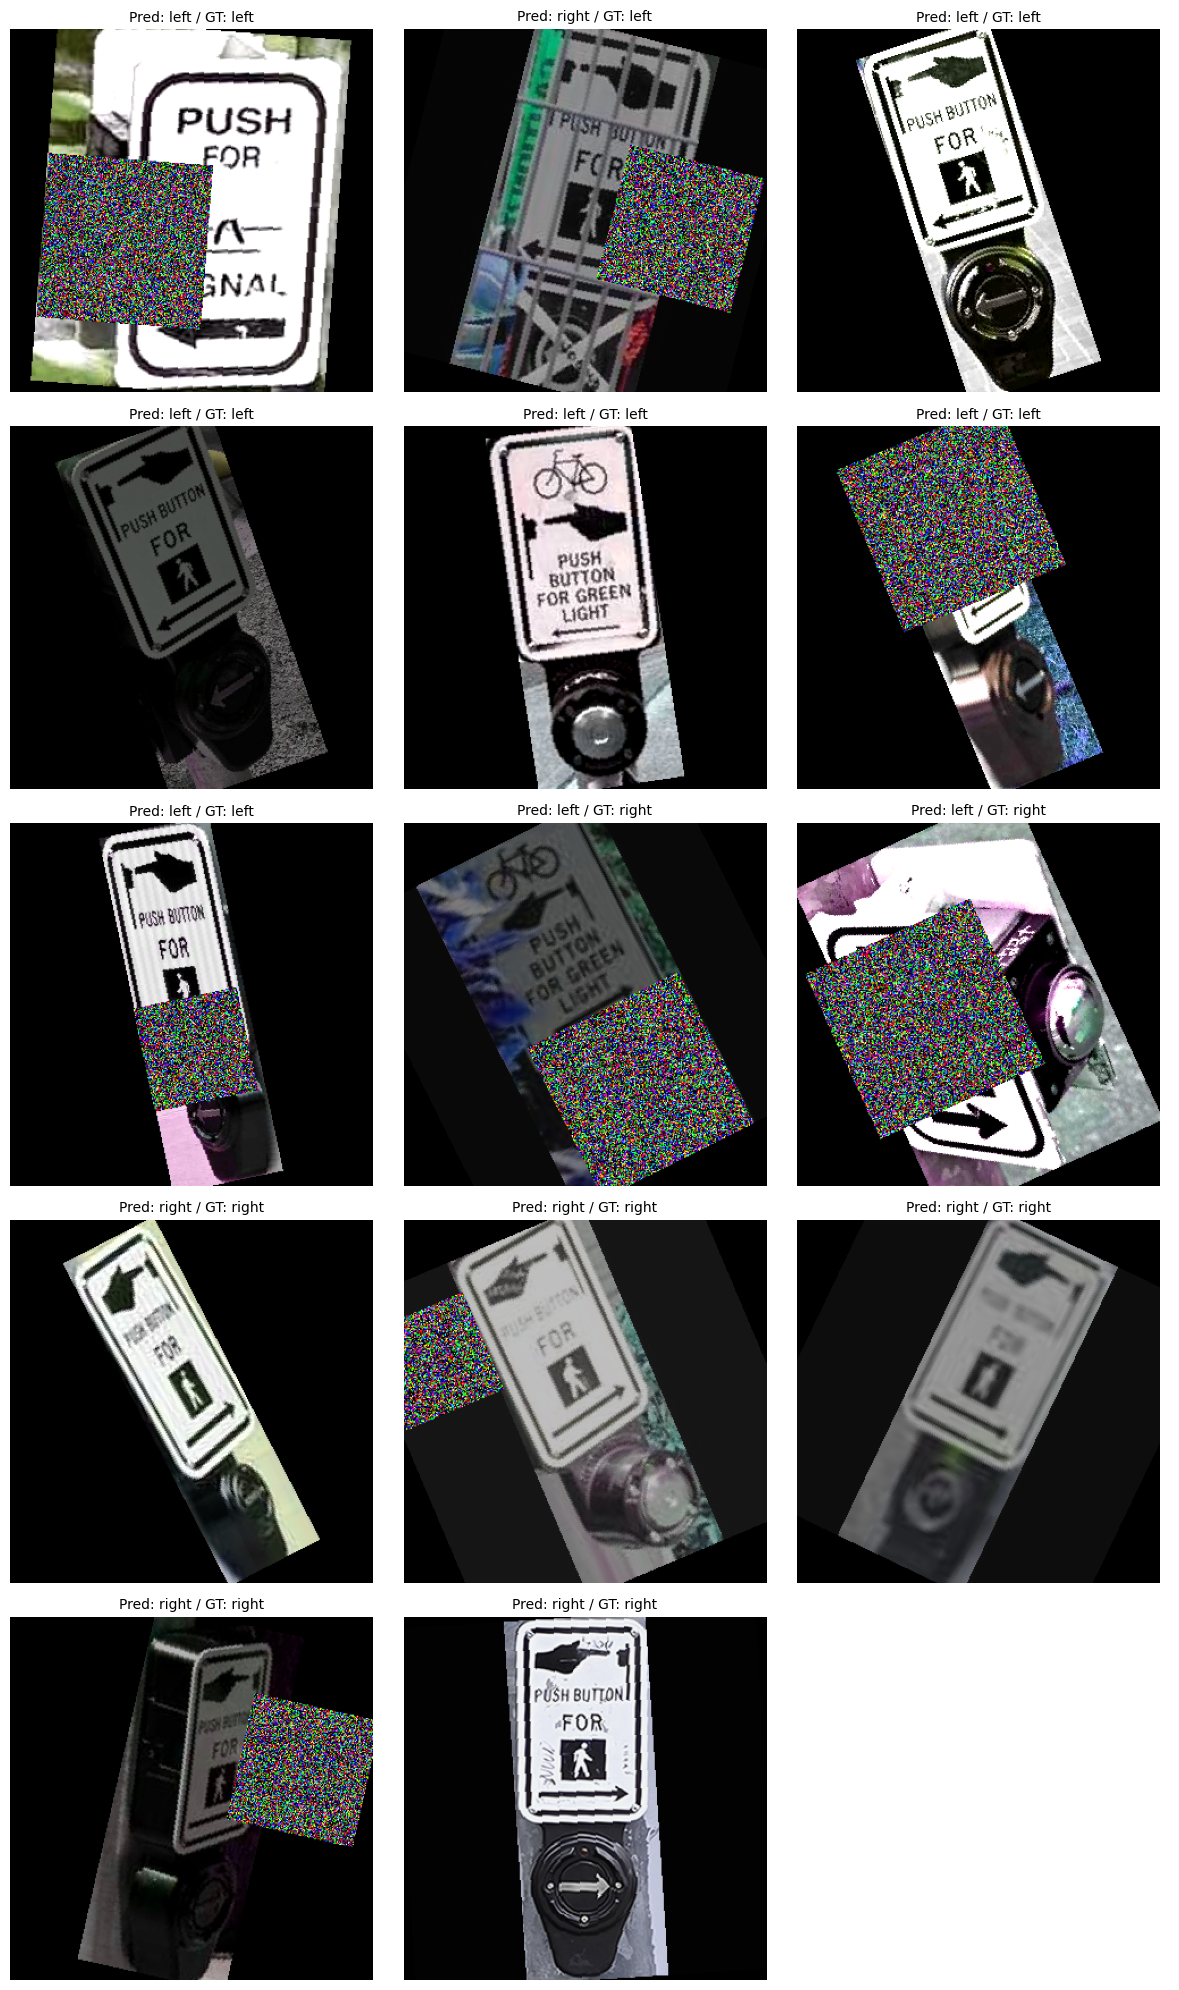

In [13]:

from utils import show_predictions_grid
show_predictions_grid(test_loader, model, device, class_names=['left', 'right'], max_images=14, images_per_row=3)


In [14]:
from utils import check_accuracy_final

print(f"Test Accuracy: {check_accuracy_final(test_loader, model, device, out=True)}")

Sample preds : [0.0%, 6.8%, 0.0%, 0.0%, 0.0%, 1.8%, 0.0%, 99.3%, 0.4%, 8.7%, 99.6%, 97.8%, 0.4%, 95.1%]
Sample labels: [0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1]
Test Accuracy: 0.7857142857142857


In [15]:
PATH = "Resnet18Backbone.pth"          # whatever name & folder you like
torch.save(model.state_dict(), PATH)